In [ ]:
import os
import sys
from sqlalchemy import Column, ForeignKey, Integer, CHAR, Date, String, Time, Index, DateTime, TIMESTAMP, func, or_
from sqlalchemy.dialects.mysql import INTEGER, BIT, TINYINT, TIME, DOUBLE, TEXT,TIMESTAMP
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine
from sqlalchemy import PrimaryKeyConstraint
from sqlalchemy.orm import sessionmaker
server = 'Your AWS address'
connection_string = 'mysql+mysqldb://root:MYSQLPassword@{}:3306/findas'.format(server)
engine = create_engine(connection_string, pool_recycle = 3600, encoding='utf-8')

Base = declarative_base()

class rent(Base):
    __tablename__ = 'rent'
    idandtype = Column(String(15), primary_key = True, nullable = False, autoincrement = False)
    productname = Column(String(50), nullable= False, default = None)
    interest_type = Column(String(20),nullable = False, default = None)
    company = Column(String(50), nullable= False, default = None)
    lowest_rate = Column(DOUBLE, nullable= False, default = None)
    highest_rate = Column(DOUBLE, nullable= False, default = None)
    last_month_interest = Column(DOUBLE, nullable = True, default = None )
    maximum_period = Column(INTEGER, nullable = True, default = None )
    preference = Column(TEXT, nullable = True, default = None)
    redemption_fee = Column(TEXT, nullable = True, default = None)
    related_fee = Column(TEXT, nullable = True, default = None)
    review_counts = Column(INTEGER, nullable = False, default = 0)
    average_rate = Column(DOUBLE, nullable = True, default = None)


class reviews(Base):
    __tablename__ = 'reviews'
    reviewid = Column(INTEGER, nullable = False, autoincrement = True, primary_key = True)
    date = Column(String(15), nullable = False, autoincrement = False, primary_key = False)
    idandtype = Column(String(15), nullable = False, autoincrement = False)
    total_rating = Column(DOUBLE,nullable = False, default = None)
    interest_sat = Column(INTEGER,nullable = False, default = None)
    online_sat = Column(INTEGER, nullable = False, default = None)
    prof_sat = Column(INTEGER, nullable = False, default = None)
    service_sat = Column(INTEGER, nullable = False, default = None)
    review = Column(TEXT,nullable = True, default = None)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 주택담보대출 & 전월세 대출 상품 분석을 통한 전략제시
* 데이터 product id가 다르더라도 같은 상품이 중복되어 나타나는 경우가 존재. 이를 제거하고 중복되지 않는 상품만 rent_df에 불러옴
* 핀다에서 주택담보대출과 전월세 대출 상품의 경우  사용자들의 리뷰를 금융 기관을 기준으로 분류되어 있으므로 같은 회사의 제품이면 평가가 동일
* 총 212개의 주택담보대출 상품 중 75개의 상품의 전월 평균 금리를 0%라고 표현하고 있음
* 전월 평균 금리를 표시한 주택담보대출 상품의 경우 평균적으로 4.91%의 전월평균 금리를 나타냄


In [ ]:
# df = pd.read_sql('''select * from(select * from rent order by productname,company,idandtype desc ) rentsc group by productname,company''',engine)
# mort_df = df.ix[df['idandtype'].apply(lambda x : 'MORT' in x),:]
# rent_df = df.ix[df['idandtype'].apply(lambda x : 'RENT' in x),:]
mort_df = pd.read_csv('mort_df.csv')
print('대출 금리를 0%라고 표시한 주택담보대출 상품의 개수',sum(mort_df['last_month_interest']==0))
print('\n주택담보대출 상품\n', mort_df[mort_df['last_month_interest']!=0][['lowest_rate','highest_rate','last_month_interest']].describe())

대출 금리를 0%라고 표시한 주택담보대출 상품의 개수 75

주택담보대출 상품
        lowest_rate  highest_rate  last_month_interest
count   141.000000    141.000000           141.000000
mean      4.011418      7.438582             4.910709
std       1.318450      4.083306             2.086082
min       0.000000      0.000000             2.640000
25%       3.030000      4.460000             3.300000
50%       3.560000      5.710000             3.880000
75%       4.800000      9.350000             6.450000
max       8.000000     23.000000            15.000000


* 상품 분류를 위한 KMeans 알고리즘 사용
    * 주택 담보 대출 상품의 분류를 위해 K-means 알고리즘을 사용하여 전체 상품을 총 7가지 상품으로 분류해본다.

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(init="k-means++", n_clusters=7, random_state=42,max_iter = 600).fit(mort_df[['lowest_rate','highest_rate','last_month_interest']])
mort_df['cluster'] = model.predict(mort_df[['lowest_rate','highest_rate','last_month_interest']])
X = np.asarray(mort_df[['lowest_rate','highest_rate','last_month_interest','cluster']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


* 첫 번째 클러스터에는 전월 평균 금리가 5 % 를 넘지 않는 중저 금리 상품, 두번째 클러스터에는 상품의 금리가 정확히 기재되지 않는(0%로 표시된)  상품들이 나탄난것을 확인할 수 있다.
* 이와 같은 방식으로 각각의 클러스터에는 다음과 같은 특징이 나타난다.
    * cluster 0 : 최저 금리 2~3% 전월 평균 금리 2~4%의 저금리 상품
    * cluster 1 : 금리 정보가 표시되지 않는 제 1금융권 상품
    * cluster 2 : 전월 평균금리 6~10% 최고금리 10% 이상 15% 미만의  고정금리 제 2금융권 주택담보대출 상품
    * cluster 3 : 전월 평균금리 6~10% 최고금리 10% 미만의 제2금융권 상품
    * cluster 4 : 최고 금리 15% 이상의 전월 평균금리 8% 이상의 제 2금융권 상품
    * cluser 5 :  최저 금리 2~3% 이고 전월 평균 금리가 표시되지 않는 상품
    * cluster 6 : 전월 평균 금리가 4~7% 수준으로 나타나지만 최고 금리가 15%이상의 제2 금융권 상품들

In [ ]:
from tabulate import tabulate

def decode_txt(strs):
    try:
        return strs.decode('utf-8')
    except (AttributeError, UnicodeDecodeError):
        return strs

cluster_0_table = tabulate(
    mort_df[mort_df.cluster == 0]
    .applymap(decode_txt)[['productname', 'interest_type', 'company', 'lowest_rate', 'highest_rate', 'last_month_interest']]
    .head(20),
    headers=[u'제품명', u'금리종류', u'기업', u'최저', u'최고', u'전월평균'],
    tablefmt='psql'
)

cluster_1_table = tabulate(
    mort_df[mort_df.cluster == 1]
    .applymap(decode_txt)[['productname', 'interest_type', 'company', 'lowest_rate', 'highest_rate', 'last_month_interest']]
    .head(20),
    headers=[u'제품명', u'금리종류', u'기업', u'최저', u'최고', u'전월평균'],
    tablefmt='psql'
)

print(cluster_0_table)
print(cluster_1_table)

+----+-----------------------------------+------------+------------+--------+--------+------------+
|    | 제품명                            | 금리종류   | 기업       |   최저 |   최고 |   전월평균 |
|----+-----------------------------------+------------+------------+--------+--------+------------|
|  1 | 6개월 변동금리 - APT론            | 변동       | star_sb    |   3.1  |   7.2  |       4.2  |
|  4 | BNK357금리안심모기지론            | 고정       | bnkbs      |   3.4  |   4.96 |       3.4  |
|  5 | BNK금리상한 모기지론              | 변동       | bnkbs      |   3.01 |   5.37 |       3.26 |
|  6 | BNK행복스케치 모기지론            | 변동       | bnkbs      |   3.11 |   5.67 |       4.35 |
|  7 | DGB HYBRID 모기지론(구입)         | 고정       | dgb        |   3.03 |   5.5  |       3.16 |
|  8 | DGB HYBRID 모기지론(생활)         | 고정       | dgb        |   3.03 |   5.24 |       3.15 |
|  9 | DGB 장기모기지론(구입)            | 변동       | dgb        |   2.85 |   5.5  |       2.81 |
| 10 | DGB 장기모기지론(생활)            | 변동       | dgb        |   2.85 |   5.25 |       

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

* 클러스터된 상품의 분포를 나타낸 그래프

AttributeError: ignored

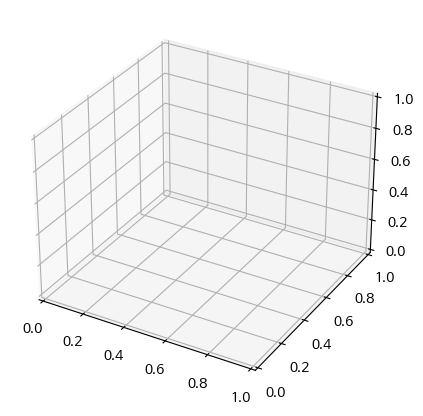

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Use 'NanumBarunGothic' as the font name
font_name = "NanumBarunGothic"

# Set the font for matplotlib
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다.

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

labels = model.labels_
cmap = mpl.cm.get_cmap('jet', len(np.unique(labels)))
normalize = mpl.colors.Normalize(vmin=np.min(labels), vmax=np.max(labels))
colors = [cmap(normalize(label)) for label in labels]

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, s=100, cmap='jet')

ax.set_xlabel('최저금리')
ax.set_ylabel('최고금리')
ax.set_zlabel('전월평균 금리')
plt.title('상품의 금리로 분류한 주택담보대출 상품', fontsize=20)

plt.show()


* 주택 담보대출 상품의 총 리뷰 분석
    * 주택 담보 대출 상품의 경우 우리은행의 상품이 23개로 가장 많이 게재되었고 그뒤를 신한은행, KB국민은행, KEB하나은행 순으로 게재되어있다.
    * KB국민은행의 상품들이 47개의 리뷰를 받으면서 가장 많은 리뷰를 받고있고 그뒤를 우리은행, 농협은행의 상품들이 뒤따르고 있다.
    * 농협은행은 상품 수 대비 가장 높은 리뷰를 받고있는 것으로 나타남
    * 총 68개의 기업의 주택담보대출 상품들이 리뷰를 받은적이 없는 것으로 나타남  

상품 리뷰를 받지 못한 주택담보대출 상품 68
AJU_SB ,
INCHEON_SB ,
JI_SB ,
YEGARAM_SB ,
JTCHINAE_SB ,
KB_SB ,
KDB ,
KDB_LIFE ,
KUKJE_SB ,
NH_FIRE ,
NH_LIFE ,
NH_SB ,
OK_SB ,
OSB_SB ,
OSUNG_SB ,
PEPPER_SB ,
PUREUN_SB ,
SAMHO_SB ,
SBI_SB ,
SHINAN_SB ,
SHINHAN_LIFE ,
SHINHAN_SB ,
SJ_SB ,
SMART_SB ,
SOULBRAIN_SB ,
STAR_SB ,
THEK_SB ,
TS_SB ,
UNION_SB ,
YC_SB ,
HYUNDAI_SB ,
HK_SB ,
JINJU_SB ,
YJ_SB ,
CHEONGJU_SB ,
BULIM_SB ,
DAEA_SB ,
DAEHAN_SB ,
DAEWON_SB ,
DAISHIN_SB ,
DH_SB ,
DM_SB ,
CH_SB ,
ASAN_SB ,
GANGWON_SB ,
ANYANG_SB ,
GUMI_SB ,
CENTRAL_SB ,
ANGUK_SB ,
HANA_SB ,
ALLIANZ_LIFE ,
GORYO_SB ,
HYUNDAI_LIFE ,
SERAM_SB ,
DEBEC_SB ,
DREAM_SB ,
HANSUNG_SB ,
PT_SB ,
IBK_SB ,
SAMSUNG_FIRE ,
KI_SB ,
BNKGN ,
DONGBU_INS ,
HEUNGKUK_FIRE ,
KB_INS ,
HEUNGKUK_LIFE ,
HANWHA_INS ,
KYOBO_LIFE ,


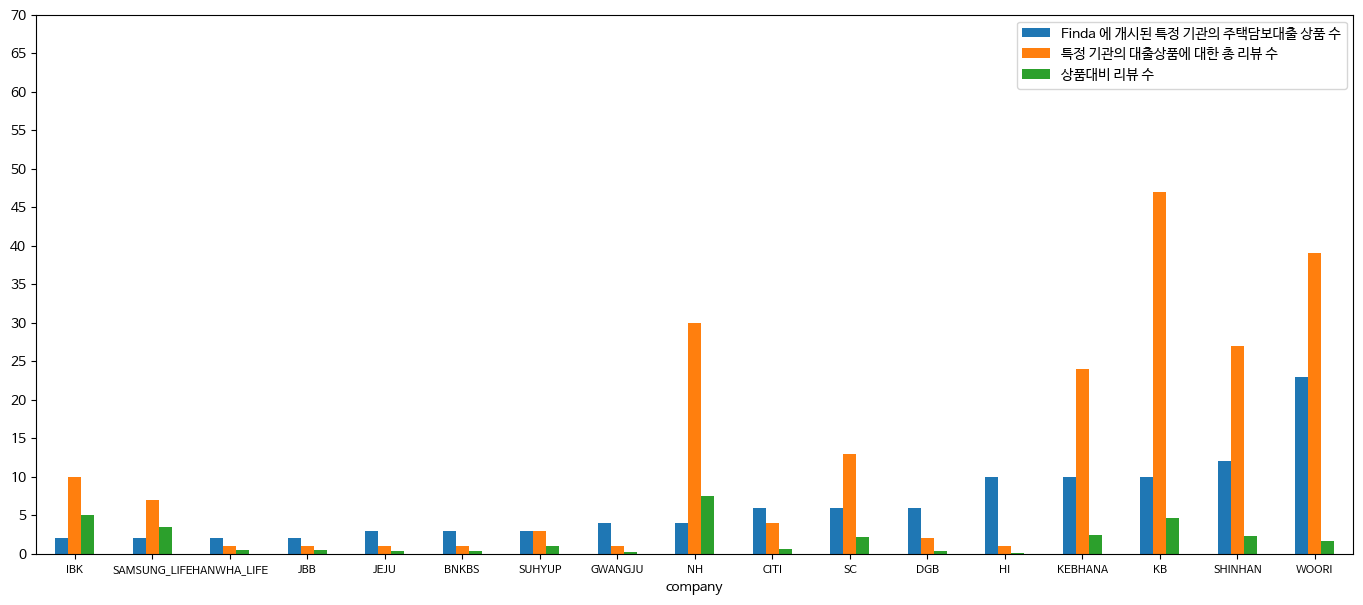

In [ ]:
from matplotlib import font_manager, rc
# Use 'NanumBarunGothic' as the font name
font_name = "NanumBarunGothic"

# Set the font for matplotlib
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다.

mort_grouped = mort_df.groupby('company')
productcounts = mort_grouped.agg({'productname': pd.Series.nunique,'review_counts': np.mean})
productcounts['상품대비 리뷰 수 '] = productcounts['review_counts'] / productcounts['productname']
productcounts.rename(columns={'productname': 'Finda 에 개시된 특정 기관의 주택담보대출 상품 수','review_counts':'특정 기관의 대출상품에 대한 총 리뷰 수'}, inplace=True)
productcounts.reset_index(inplace= True)
productcounts['company'] = productcounts['company'].apply(lambda x: x.upper())
productcounts.sort_values('Finda 에 개시된 특정 기관의 주택담보대출 상품 수',inplace = True)
productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] > 0].plot(x = 'company',kind = 'bar',figsize = (17,7),yticks = (np.arange(0,15)*5),style = True,)
plt.xticks(fontsize = 8,rotation = 0)
print('상품 리뷰를 받지 못한 주택담보대출 상품',len(list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company'])))
for notreviewd in list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company']):
    print(notreviewd,',')

* 리뷰를 받은 상품과 리뷰를 받지 못한 전월 평균 금리를 비교해 보면 리뷰를 받은 상품의 전월 평균 금리는 대게 0%로 나타난다. 이는 실제 금리가 0%라는 의미가 아니라 정보를 공개하지 않은 것

* 전월 평균금리 5%이상의 고금리 주택담보대출 상품에는 사용자들의 평가가 존재하지 않음
    * 현재 핀다사이트 이용고객이 대게 은행권 대출 가능고객들로 이루어진것을 확인 할 수 있음
    * 대출 조건 검색 시 제 1금융권 검색을 우선으로 설정한 핀다 사이트의 특성과도 연관 있음

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


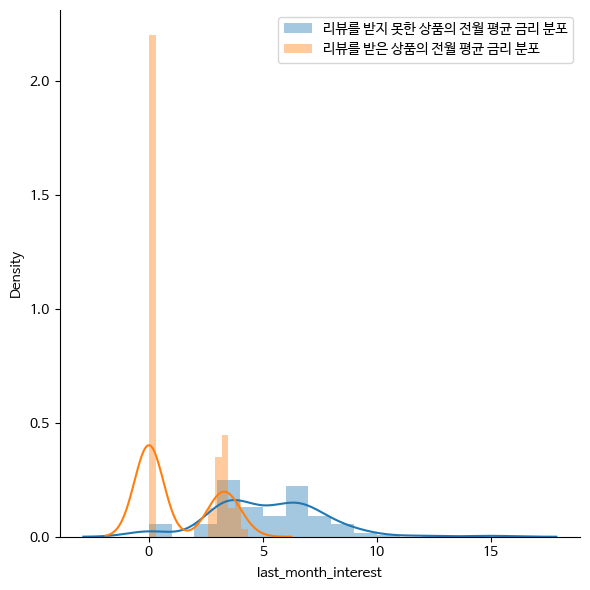

In [ ]:
mort_df['reviewed'] = mort_df['review_counts'] > 0
sns.FacetGrid(mort_df, hue='reviewed', height=6).map(sns.distplot, 'last_month_interest', bins=15)
L = plt.legend()
L.get_texts()[0].set_text(u'리뷰를 받지 못한 상품의 전월 평균 금리 분포')
L.get_texts()[1].set_text(u'리뷰를 받은 상품의 전월 평균 금리 분포')

* 주택담보대출 상품의 댓글 분석
    * 각 기업의 상품에는 같은 댓글이 달려있으므로 기업별로 하나의 상품만을 선정하여 댓글을 가져오면 된다.

In [ ]:
representative = tuple(mort_df.groupby('company').first()['idandtype'])#각각의 기업별 상품의 id가 하나씩 선택된 tuple
mort_reviews = pd.read_sql('select * from reviews where idandtype in {} '.format(representative),engine)
# mort_reviews = pd.read_csv('mort_reviews.csv',encoding = 'utf-8')
mort_com = mort_df.groupby('company').first()[['idandtype','review_counts']].reset_index()
mort_reviews = pd.merge(mort_com,mort_reviews,on = 'idandtype')

* 5개이상의 리뷰를 기록한 상품들 중에서 삼성생명의 상품들이 가장 높은 총점을 기록했다. 특히 가장 높은 서비스 만족도를 기록하면서 좋은성과를 보여주었다.
* KB 국민은행의 경우에는 온라인 대응 부분에서 좋지 않은 평가를 받으면서 가장 낮은 평점을 기록했다.  

In [ ]:
mort_reviews['company'] = mort_reviews['company'].apply(lambda x: x.upper())
mort_reviews[mort_reviews.review_counts > 5].groupby('company').mean().sort_values('total_rating')[['interest_sat','online_sat','prof_sat','service_sat','total_rating']].plot(kind = 'bar',figsize = (16,9),style = True)
plt.xticks(fontsize = 12,rotation = 0)
plt.legend(loc = 2)

AttributeError: ignored

* 국민은행의 상품에 대해 낮은 온라인 편의성 점수를 부여한 리뷰를 분석:
    * 온라인 편의성에 대한 직접적인 불만을 나타낸 댓글은 많지 않지만 본사 사이트에 소개한 상품이 실제로 취급되지 않는 경우가 많다는 댓글이 있고 고객들 모두 오프라인 상담의 친절성을 주로 언급한 반면 온라인 서비스에 대한 언급은 없음

In [ ]:
kb = mort_reviews[(mort_reviews.company == 'KB') & (mort_reviews.online_sat < 3)]
for kbreview,online_sat in zip(kb['review'],kb['online_sat']):
    print('온라인편의성 평점:',online_sat,'\n','댓글 내용:',kbreview,'\n')

AttributeError: ignored

* 삼성 생명의 주택담보대출 상품의 댓글을 분석해본 결과  서비스 점수에 높은 점수를 부여한  분석해본 결과 전반적으로 까다롭지 않는 진행절차와 중도 상환 수수료상의 장점등을 나타내고 있음

In [ ]:
samsung = mort_reviews[(mort_reviews.company == 'samsung_life') ]
for samsungreview,service_sat in zip(samsung['review'],samsung['service_sat']):
    print('서비스 만족도 평점:',service_sat,'\n','댓글 내용:',samsungreview,'\n')

# 전월세대출 분석
* 전월세 상품의 경우 총 62개의 상품 중에서 35개의 상품이 대출금리를 정확하게 명시하지 않고 있음
* 전월세 상품의 경우 평균적으로 4.76%의 전월 평균 금리를 나타내고 있음

In [ ]:
# rent_df = df.ix[df['idandtype'].apply(lambda x : 'RENT' in x),:]
rent_df = pd.read_csv('rent_df.csv',encoding = 'utf-8')
print('대출 금리를 0%라고 표시한 전월세 대출 상품의 개수',sum(rent_df['last_month_interest']==0))
print('\n전월세 대출 상품\n', rent_df[rent_df['last_month_interest']!=0][['lowest_rate','highest_rate','last_month_interest']].describe())

대출 금리를 0%라고 표시한 전월세 대출 상품의 개수 35

전월세 대출 상품
        lowest_rate  highest_rate  last_month_interest
count    62.000000     62.000000            62.000000
mean      3.908226      6.827742             4.769355
std       1.520256      4.439500             2.465968
min       2.520000      3.150000             2.620000
25%       2.902500      4.320000             3.137500
50%       3.430000      5.300000             3.665000
75%       4.327500      7.775000             6.150000
max       9.400000     25.000000            16.000000


* 핀다사이트에는 게재된 전월세 대출 상품 중에서 우리은행의 상품이 13개로 가장 많이 게재되있고 kb와 신한은행의 상품이 각각 10개씩 게재되어 있음
* 리뷰 역시 우리은행의 상품군에 69개로 가장 많은 리뷰가 이루어졌고 이를 신한은행, KB국민은행 순으로 따르고 있음

상품 리뷰를 받지 못한 주택담보대출 상품 31
ALLIANZ_LIFE ,
INSUNG_SB ,
JINJU_SB ,
KI_SB ,
KIWOOM_SB ,
KYOBO_LIFE ,
LOTTE_INS ,
HYUNDAI_SB ,
MOA_SB ,
SAMHO_SB ,
SAMSUNG_FIRE ,
SAMSUNG_LIFE ,
SHINHAN_LIFE ,
SMART_SB ,
SOULBRAIN_SB ,
MYANGEL ,
HK_SB ,
HEUNGKUK_LIFE ,
ASAN_SB ,
BULIM_SB ,
CHEONGJU_SB ,
DAEHAN_SB ,
DY_SB ,
GUMI_SB ,
YEGARAM_SB ,
HEUNGKUK_FIRE ,
GORYO_SB ,
DGB ,
HI ,
DONGBU_INS ,
CITI ,


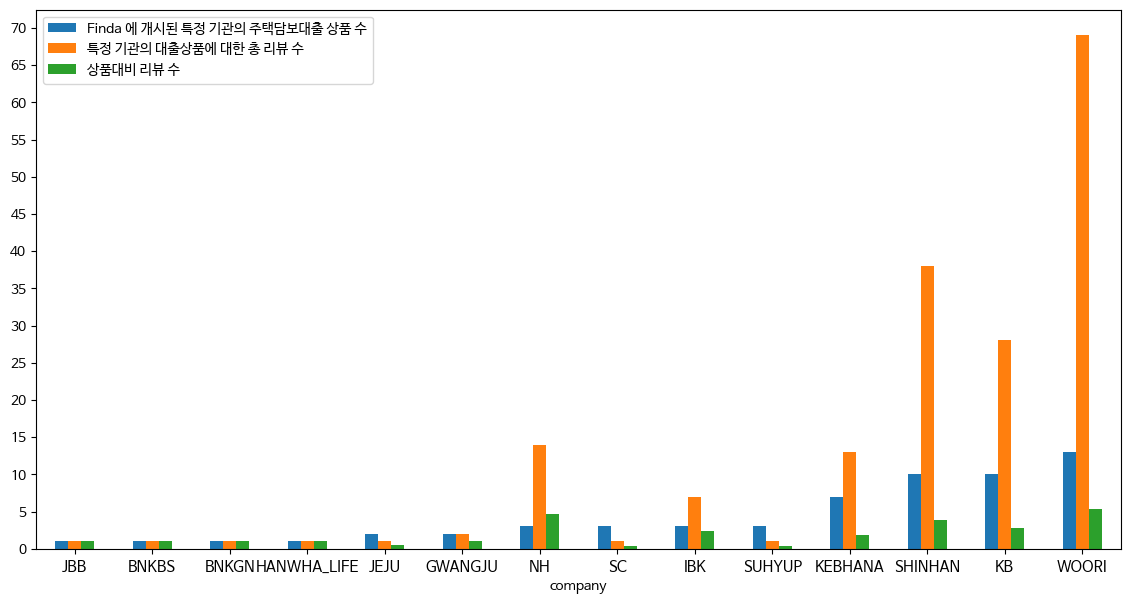

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib import font_manager, rc
rent_grouped = rent_df.groupby('company')
productcounts = rent_grouped.agg({'productname': pd.Series.nunique,'review_counts': np.mean})
productcounts['상품대비 리뷰 수 '] = productcounts['review_counts'] / productcounts['productname']
productcounts.rename(columns={'productname': 'Finda 에 개시된 특정 기관의 주택담보대출 상품 수','review_counts':'특정 기관의 대출상품에 대한 총 리뷰 수'}, inplace=True)
productcounts.reset_index(inplace= True)
productcounts['company'] = productcounts['company'].apply(lambda x: x.upper())
# Use 'NanumBarunGothic' as the font name
font_name = "NanumBarunGothic"

# Set the font for matplotlib
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다.
productcounts.sort_values('Finda 에 개시된 특정 기관의 주택담보대출 상품 수',inplace = True)
productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] > 0].plot(x = 'company',kind = 'bar',figsize = (14,7),yticks = (np.arange(0,15)*5),style = True,)
plt.xticks(fontsize = 11,rotation = 0)
print('상품 리뷰를 받지 못한 주택담보대출 상품',len(list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company'])))
for notreviewd in list(productcounts[productcounts['특정 기관의 대출상품에 대한 총 리뷰 수'] == 0]['company']):
    print(notreviewd,',',)


* 전월세 대출 상품도 주택담보대출 상품과 마찬가지로 전월 평균금리 5%이상의 상품군에서 리뷰를 받은 상품이 없는것으로 나타남

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


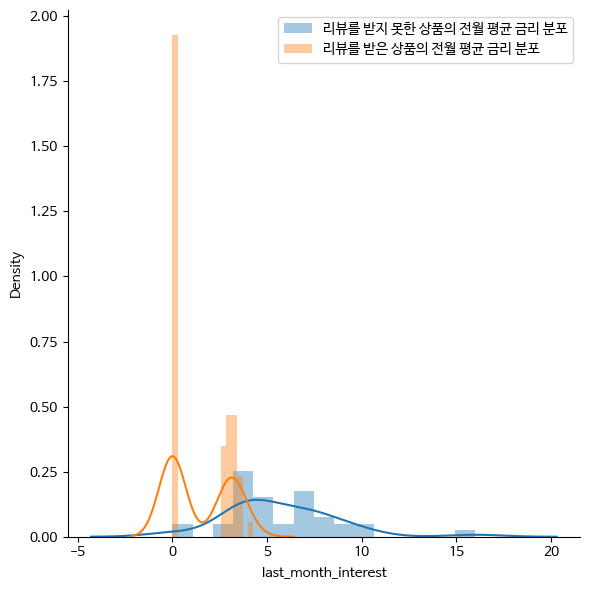

In [ ]:
rent_df['reviewed'] =  rent_df['review_counts'] > 0
sns.FacetGrid(rent_df, hue='reviewed', height=6).map(sns.distplot, 'last_month_interest', bins=15)
L=plt.legend()
L.get_texts()[0].set_text(u'리뷰를 받지 못한 상품의 전월 평균 금리 분포')
L.get_texts()[1].set_text(u'리뷰를 받은 상품의 전월 평균 금리 분포')

In [ ]:
representative = tuple(rent_df.groupby('company').first()['idandtype'])#각각의 기업별 상품의 id가 하나씩 선택된 tuple
# rent_reviews = pd.read_sql('select * from reviews where idandtype in {} '.format(representative),engine)
rent_reviews = pd.read_csv('rent_reviews.csv',encoding = 'utf-8')
rent_com = rent_df.groupby('company').first()[['idandtype','review_counts']].reset_index()
rent_reviews = pd.merge(rent_com,rent_reviews,on = 'idandtype')

* 리뷰가 5개이상 달린 상품 중 KEB하나 은행의 경우 서비스 만족도와 온라인 편의에서 가장 낮은 점수를 받아 가장 낮은 총점을 기록하였다.

In [ ]:
rent_reviews['company'] = rent_reviews['company'].apply(lambda x: x.upper())
rent_reviews[rent_reviews.review_counts > 5].groupby('company').mean().sort_values('total_rating')[['interest_sat','online_sat','prof_sat','service_sat','total_rating']].plot(kind = 'bar',figsize = (16,9),style = True)
plt.xticks(fontsize = 12,rotation = 0)
plt.legend(loc = 2)

KeyError: ignored

* 실제 하나은행의 상품 중 직원들에게 받은 서비스에 대한 불만을 나타내는 리뷰가 30% 가량 나타났다.  

In [ ]:
keb = rent_reviews[(rent_reviews.company == 'KEBHANA') & (rent_reviews.online_sat < 3)]
print('상담의 불만을 나타낸 댓글의 비율',float(len(keb)) / len(rent_reviews[rent_reviews.company == 'KEBHANA']),'\n')
for kebreview,online_sat in zip(keb['review'],keb['online_sat']):
    print('온라인편의성 평점:',online_sat,'\n','댓글 내용:',kebreview,'\n')

AttributeError: ignored